In [1]:
import pandas as pd
import numpy as np
import string
from pathlib import Path
from retell_utils.corpora_sugar import CorpusSugar
from retell_utils.metrics import get_cosine_sim, jaccard_text,show_statistics_and_bar
from tg.grammar_ru.corpus import CorpusReader
import retell_utils.statistical as stat_utils

In [2]:
retell_corpus = CorpusReader(Path("./featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("./featurized_corpuses/books.featurized.zip"))

In [3]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')

In [4]:
ban_words = set(string.punctuation + "«—»…")
ban_words.update(["!!", "!?", "?!", "??", "?.."])

In [5]:
stat_extract_retell = stat_utils.get_extract_retell_by_common_word(books,corpus_sugar.get_sentences_with_norm_form,ban_words=ban_words,retell_detail=5)

  0%|          | 0/82 [00:00<?, ?it/s]

In [6]:
true_retell = corpus_sugar.get_true_retell('Мартин',"retell",retell_detail=5)

In [7]:
jaccard_sim = np.array([jaccard_text(stat_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])
cos_sim = np.array([get_cosine_sim(stat_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])

median Индекс Жаккара: 0.095
max Индекс Жаккара: 0.17
min Индекс Жаккара: 0.044
------------------------------------
median Косинусное расстояние: 0.18
max Косинусное расстояние: 0.38
min Косинусное расстояние: 0.024
------------------------------------


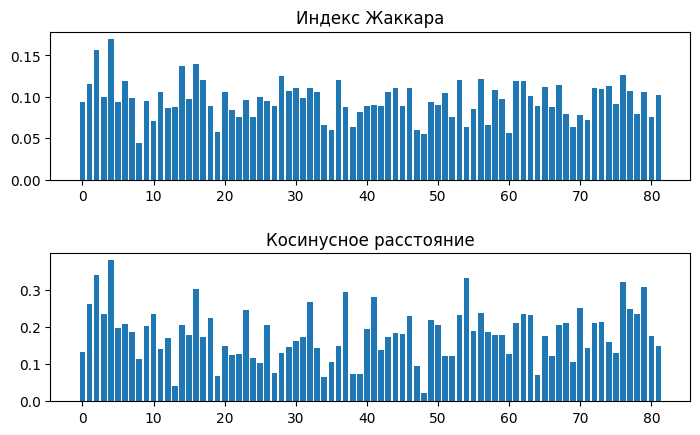

In [8]:
show_statistics_and_bar(jaccard_sim,cos_sim)